<a href="https://colab.research.google.com/github/erikmcguire/textworld_light/blob/main/Light_TTR_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set path to data folder to use in notebook. Install and import dependencies.

For significance tests: install scipy >= 1.10.0 (for `permutation_test`) now to avoid having to restart and lose variables, etc. when installing and restarting later.

In [ ]:
DATA_PTH = "/../content/drive/MyDrive/data/light_data/"

In [ ]:
!pip3 install scipy==1.10.0 &> /dev/null
!pip install pingouin pyyaml==5.4.1 &> /dev/null

In [ ]:
import scipy
scipy.__version__

In [ ]:
import spacy
from scipy import stats
import pandas as pd
from collections import Counter
import warnings
import sys
import random
import numpy as np
from itertools import product
import pandas as pd
from collections import Counter
import numpy as np

In [ ]:
import pingouin as pg

# I. Create verb-object count dictionaries

### 1. Install spacy transformers if necessary.

In [ ]:
!pip install spacy-transformers &> /dev/null

In [ ]:
!python3 -m spacy download en_core_web_trf

In [ ]:
import spacy_transformers

In [ ]:
# spacy.prefer_gpu()
spacy.require_gpu()
nlp = spacy.load('en_core_web_trf')

### 2. Definitions for parsing direct objects

In [ ]:
vset = {'drink','drop','eat','follow','get','give',
        'go','hit','hug','put','remove','steal',
        'use','wear','wield'}

def get_object(doc):
    # https://subscription.packtpub.com/book/data/9781838987312/2/ch02lvl1sec16/extracting-subjects-and-objects-of-the-sentence
    for token in doc:
        if ("dobj" in token.dep_):
            subtree = list(token.subtree)
            start = subtree[0].i
            end = subtree[-1].i + 1
            return doc[start:end]

def get_o(vo, doc):
    # The 15 Light commands
    vset = ['drink','drop','eat','follow','get','give',
            'go','hit','hug','put','remove','steal',
            'use','wear','wield']
    try:
        nc = next(doc.noun_chunks)
    except:
        pass
    for token in doc:
        if str(token) in vset and str(token.dep_) != "ROOT":
            # probably needs det if first verb not root
            vo2 = vo.split()[0] + " a " + " ".join(vo.split()[1:])
            doc = nlp(vo2)
            for token in doc:
                # try def vs indef articles if still does't work
                if str(token) in vset and str(token.dep_) != "ROOT":
                    vo3 = vo.split()[0] + " the " + " ".join(vo.split()[1:])
                    doc = nlp(vo3)
    for token in doc:
        if str(token) in vset and str(token.dep_) != "ROOT":
            # give up and use latter part of original action
            o = " ".join(vo.split()[1:])
        elif str(token) in vset and str(token.dep_) == "ROOT":
            o = get_object(doc)
            o = str(o)
            o = o.replace("the ", "").replace("a ", "")
            try:
                nctr = nc.text.replace("the ", "").replace("a ", "")
                if nctr.split(" ")[0] in vset:
                    nctr = " ".join(nctr.split(" ")[1:])
                if o not in nctr:
                    o = nctr
            except:
                pass
    if o == "None":
        o = " ".join(vo.split()[1:])
    return o

### 3. Create dictionaries from original or generated data

In [ ]:
#@title ###### a. Run cell to select whether to load original or genderated split data, generation mode (sample or beam)
gen = "true" #@param ["true", "false"]
genmd = "quest_sampl" #@param ["quest_sampl", "quest_beaml"]

- Define function to get command counts per gender keyed by actions, that is, set of objects each action applied to.
- Define function to collect single word objects.
- Load data and use to get counts of verb-parsed objects.
- Get list of simple objects, then if that object in multiword list, remove multi, increment simple
- Collect and combine object sets per gender.
- Create counter of affordance pairings for each object.

In [ ]:
#@title Define utils

def get_vod(df, ky):
    """Create counts of commands (action-object pairings) per gender,
    e.g. male: wield+sword (vod_df["M"]["wield"]["sword"])
    occurs 58 times
    """
    vod = {g: {v: Counter()
            for v in vset}
       for g in ["M", "F", "N"]}
    # Count
    for g in ["M", "F", "N"]:
        vo_pairs_g = df[df.gender == g][ky]
        for vol in vo_pairs_g.tolist():
            for vo in vol:
                v = vo.split()[0]
                doc = nlp(vo)
                o = get_o(vo, doc)
                if not o.strip():
                    o = " ".join(vo.split()[1:])
                vod[g][v][o] += 1
    return vod

def get_simplified(vod_df):
    for g in ["M", "F", "N"]:
        objects = set() # create initial list of single word objects
        for v, od in vod_df[g].items():
            for o, c in od.items():
                if len(o.split(" ")) == 1:
                    objects.add(o)
        # replace instances where duplicates hidden by modifiers
        # e.g. as in multiword yet contains object above
        # ex: 'hot tea' can be seen as dupe of 'tea'
        for v, od in vod_df[g].items():
            new_od = Counter(od) # can't change od size during loop
            for o, c in od.items():
                maybe_add = []
                if len(o.split(" ")) > 1: # ex: 'hot tea'
                    old_o = o
                    o = o.split(" because ")[0]
                    o = o.split(" and ")[0]
                    o = o.split(" from ")[0]
                    o = o.split(" to ")[0]
                    o = o.split(" with ")[0]
                    for el in o.split(" "): # ex: ['hot', 'tea']
                        if el in objects: # e.g. 'tea' in objects
                            # Assume match can be replaced
                            # e.g. 'hot tea' effectively replaced by 'tea'
                            # by incrementing 'tea' and removing 'hot tea'
                            maybe_add.append((el, c))
                    if len(maybe_add) > 1:
                        el, c = maybe_add[-1] # could go by more common, but use final, assume prev are modifiers
                    new_od[el] += c # increment simple
                    if old_o in new_od.keys():
                        new_od.pop(old_o) # remove multiword
            vod_df[g][v] = new_od
    vod = vod_df.to_dict()
    return vod_df, vod

def get_objects(vod_df, g):
    objects = set() # create initial list of single word objects
    for v, od in vod_df[g].items():
        for o, c in od.items():
            if len(o.split(" ")) == 1:
                objects.add(o)
    return objects

def get_obj_set(vod_df):
    objects_m = get_objects(vod_df, "M")
    objects_f = get_objects(vod_df, "F")
    objects_n = get_objects(vod_df, "N")
    objects = objects_m | objects_f | objects_n
    return objects

def get_o2v(objects, vod_df):
    o2v = {g: {o: Counter() for o in objects}
           for g in ["M", "F", "N"]}
    for g in ["M", "F", "N"]:
        for v, od in vod_df[g].items():
            for o in objects:
                if o in od.keys():
                    o2v[g][o][v] += od[o]
        o2v[g] = dict(filter(lambda o: o[1], o2v[g].items()))

    assert set(pd.DataFrame.from_dict(o2v).T.keys()) == set(objects)
    o2v_df = pd.DataFrame.from_dict(o2v)
    return o2v_df, o2v

vset = {'drink','drop','eat','follow','get','give',
            'go','hit','hug','put','remove','steal',
            'use','wear','wield'}

cd = {"all": 1640, "m": 205, "f": 180, "n": 1305,
      "m_subset": 180, "all_subset": 180, "n_subset": 180}

def get_questl(x, ky):
    """ 'a, b, c' -> ['a', 'b', 'c']"""
    x[f"{ky}l"] = [c for c in x[ky].split(", ") if c.split()[0] in vset]
    return x

###### Import and load original data, generated.

In [ ]:
dfqq_gmn = pd.read_pickle(f"{DATA_PTH}dfqq_gmn.pkl")
counts = {"male": (dfqq_gmn.gender == "M").sum(),
          "female": (dfqq_gmn.gender == "F").sum(),
          "neutral": (dfqq_gmn.gender == "N").sum()}
print("Loaded dfqq_gmn dataset containing columns:")
display(dfqq_gmn.columns)
print("\n# examples per gender:\n")
for g, c in counts.items():
    print(g.capitalize(), c)

Loaded dfqq_gmn dataset containing columns:


Index(['character', 'persona', 'description', 'goal', 'short_motivation',
       'mid_motivation', 'long_motivation', 'timeline', 'quest', 'questl',
       'verbs', 'character_sm', 'location', 'clsm', 'gender', 'gverb',
       'agencies', 'locations', 'characters', 'foods', 'objects'],
      dtype='object')


# examples per gender:

Male 936
Female 570
Neutral 5980


##### 1. Create gender-annotated generation data if necessary.

###### a. If annotating generated data with gender, first load generated
###### b. Rename column for merging; merge to add gender annotation to generated.
###### c. Convert quest string into list of commands for quests generated from both generation methods.
###### d. Save for this split.

In [ ]:
dfqq_gmn = dfqq_gmn.rename({"clsm": "prompt"}, axis=1)

In [ ]:
#@title Bulk load generated quests and merge generation methods (sampling, beam), convert quests to lists
save_genderated = False #@param {'type': 'boolean'}
for gnsd in [42, 7304, 7696]:
    for gnder in cd.keys():
        for split in ["train", "dev", "test"]:
            generated = pd.read_pickle(f"{DATA_PTH}generated_{split}_merged_{gnder.lower()}_{gnsd}.pkl")
            genderated = pd.merge(generated, right=dfqq_gmn.loc[:, ["gender", "prompt"]], on="prompt")
            genderated = genderated.rename({"quest_gen": "quest_samp"}, axis=1)
            genderated = genderated.apply(lambda y: get_questl(y, ky='quest_samp'), axis=1)
            genderated = genderated.apply(lambda y: get_questl(y, ky='quest_beam'), axis=1)
            if save_genderated:
                genderated.to_pickle(f"{DATA_PTH}genderated_{split}_merged_{gnder.lower()}_{gnsd}.pkl")

In [ ]:
#@title Bulk create, save
save_vod = False #@param {'type': 'boolean'}
save_o2v = False #@param {'type': 'boolean'}
save_simp = False #@param {'type': 'boolean'}
if gen == "true":
    for gnder in cd.keys():
        gnder = gnder.lower()
        print(gnder)
        for gnsd in [42, 7304, 7696]:
            print(gnsd)
            for genmd in ["quest_sampl", "quest_beaml"]:
                print(genmd)
                for split in ["train", "dev", "test"]:
                    print(split)
                    genderated = pd.read_pickle(f"{DATA_PTH}genderated_{split}_merged_{gnder}_{gnsd}.pkl")
                    print("\nLoaded gender annotated merged quests.")
                    vod_df = pd.DataFrame.from_dict(get_vod(genderated, genmd))
                    if save_vod:
                        vod_df.to_pickle(f"{DATA_PTH}vod_df_genderated_{split}_{gnder}_{genmd}_{gnsd}.pkl")
                        print("Saved VOD df.")
                    vod_df, vod = get_simplified(vod_df)
                    if save_simp:
                        vod_df.to_pickle(f"{DATA_PTH}vod_df_genderated_{split}_simplified_{gnder}_{genmd}_{gnsd}.pkl") # after running fn to replace multiword on loaded vod_df.pkl
                        print("Saved simplified VOD df.")
                    objects = get_obj_set(vod_df)
                    o2v_df, o2v = get_o2v(objects, vod_df)
                    if save_o2v:
                        o2v_df.to_pickle(f"{DATA_PTH}o2v_df_genderated_{split}_{gnder}_{genmd}_{gnsd}.pkl")
                        print("Saved O2V df.\n")
else:
    dfqq_gmn = pd.read_pickle(f"{DATA_PTH}dfqq_gmn.pkl")
    vod_df = pd.DataFrame.from_dict(get_vod(dfqq_gmn, "questl"))
    if save_vod:
        vod_df.to_pickle(f"{DATA_PTH}vod_df.pkl")
        print("Saved VOD df.")
    vod_df, vod = get_simplified(vod_df)
    if save_simp:
        vod_df.to_pickle(f"{DATA_PTH}vod_df_simplified.pkl") # after running fn to replace multiword on loaded vod_df.pkl
        print("Saved simplified VOD df.")
    objects = get_obj_set(vod_df)
    o2v_df, o2v = get_o2v(objects, vod_df)
    if save_o2v:
        o2v_df.to_pickle(f"{DATA_PTH}o2v_df.pkl")
        print("Saved O2V df.\n")

# II. Load verb-object count dictionaries and analyze/visualize TTR

### A. Annotate, explore data, load created dictionaries for TTR.

##### 2. Load dictionaries created in [I](#scrollTo=OyZrggMkUVpX).

In [ ]:
#@title Select and run to load ```vod_df, o2v_df```

split = "train" #@param ["train", "dev", "test"]
gen = "false" #@param ["true", "false"]
gnder = "m_subset" #@param ["m_subset", "n_subset", "all", "m", "f", "n"]
gnsd = "42" #@param [42, 7304, 7696]
gtyp = "quest_sampl" #@param ["quest_sampl", "quest_beaml"]
if gen == "true":
    vod_df = pd.read_pickle(f"{DATA_PTH}vod_df_genderated_{split}_simplified_{gnder}_{gtyp}_{gnsd}.pkl")
    o2v_df = pd.read_pickle(f"{DATA_PTH}o2v_df_genderated_{split}_{gnder}_{gtyp}_{gnsd}.pkl")
else:
    print("Loading parsed original dataset.")
    print(f"Verb-object (affordant objects) dictionary path: {DATA_PTH}vod_df_simplified.pkl")
    print(f"Object-verb (objects' affordances) dictionary path: {DATA_PTH}o2v_df.pkl")
    vod_df = pd.read_pickle(f"{DATA_PTH}vod_df_simplified.pkl")
    o2v_df = pd.read_pickle(f"{DATA_PTH}o2v_df.pkl")
    print("Loaded as dataframes vod_df, o2v_df, set dictionaries vod, o2v.")
vod = vod_df.to_dict()
o2v = o2v_df.to_dict()
print(f"\n# objects: {o2v_df.T.keys().size}")
for g in ["M", "F", "N"]:
    print(f"{g} - # Objects with associated actions: {o2v_df[g].dropna(axis=0).size}")

Loading parsed original dataset.
Verb-object (affordant objects) dictionary path: /../content/drive/MyDrive/data/light_data/vod_df_simplified.pkl
Object-verb (objects' affordances) dictionary path: /../content/drive/MyDrive/data/light_data/o2v_df.pkl
Loaded as dataframes vod_df, o2v_df, set dictionaries vod, o2v.

# objects: 3254
M - # Objects with associated actions: 1131
F - # Objects with associated actions: 803
N - # Objects with associated actions: 2977


In [ ]:
#@title Filter to only objects with $\small\geq$ top-$n$ actions (reflects SS)
def sum_actions(x):
    acts = Counter()
    for g in ["M", "F", "N"]:
        if type(x[g]) != float:
            for a, c in x[g].items():
                acts[a] += c
    x["total"] = len(acts.keys())
    x["sorted_all"] = [a for a, c in acts.most_common()]
    return x
topn = 4 #@param
o2v_df2 = o2v_df.apply(sum_actions, axis=1)
o2v_df2 = o2v_df2[o2v_df2.total >= topn]
o2v2 = o2v_df2.to_dict()
print(f"Set o2v2 from o2v_df2 dataframe (only objects w/ >= {topn} actions).")
print(f"# objects: {o2v_df2.T.keys().size}")
for g in ["M", "F", "N"]:
    print(f"{g} - # Objects with associated actions: {o2v_df2[g].dropna(axis=0).size}")

Set o2v2 from o2v_df2 dataframe (only objects w/ >= 4 actions).
# objects: 823
M - # Objects with associated actions: 513
F - # Objects with associated actions: 400
N - # Objects with associated actions: 820


### B. Compute TTR

In [ ]:
#@title ##### a. Define TTR computation, sig test functions

def get_ttr(d):
    """Compute TTR, TTA."""
    ttr_d = {g: dict() for g in ["M", "F", "N"]}
    tta_d = {g: dict() for g in ["M", "F", "N"]}
    for g in ["M", "F", "N"]:
        for k, v in d[g].items():
            if type(v) != float: # is dict, not nan
                ntypes = len(v.keys()) # unique objects for action or commands for object
                ntokens = sum(v.values()) # sum counts for each command
                if ntokens == 0:
                    ttr_d[g][k] = 0
                else:
                    ttr_d[g][k] = ntypes/ntokens # set ttr for gender's object or action key
                alltypes = {t for gg in ["M", "F", "N"] if type(d[gg][k]) != float for t in d[gg][k].keys()}
                all_types = len(alltypes)
                tta_d[g][k] = ntypes/all_types
                 # Total TTR divided by # unique objects or actions
    tta_df = pd.DataFrame(tta_d)
    tta_df2 = tta_df.mean()
    ttr_df = pd.DataFrame(ttr_d)
    ttr_df2 = ttr_df.mean()
    return tta_df, ttr_df, tta_df2, ttr_df2

def statistic(x, y, axis):
    """Test statistic for permutation tests."""
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

def get_res(a, b, alpha=0.01, alt='greater'):
    res = scipy.stats.permutation_test(data=[a, b],
                                            statistic=statistic,
                                            n_resamples=10000,
                                            permutation_type='samples',
                                            alternative=alt,
                                            random_state=2222)
    mean_diff = res.statistic
    pval = res.pvalue
    d = pg.compute_effsize(a, b, eftype='cohen')
    if alt == 'greater':
        cles = pg.compute_effsize(a, b, eftype='cles')
    elif alt == 'less':
        cles = pg.compute_effsize(b, a, eftype='cles')
    else:
        cles = 0
    power = pg.power_ttest(d=d, alpha=alpha, n=len(a),
                            alternative=alt)
    return {"diff": mean_diff, "pval": pval, "sig": pval < alpha, "d": d, "cles": cles, 'power': power, 'alt': alt}

def eq_df(df):
    df = df.fillna(0)
    df = df[df.M != 0]
    df = df[df.F != 0]
    return df

##### b. Run TTR on data, format, save

In [ ]:
ttav_df_o, ttrv_df_o, ttav_df, ttrv_df = get_ttr(vod) # action -> objects

ppv = f"Diversity of objects"
print(ppv,
        f"\n\nMean gender type vs. gender token (TTR):\n{ttrv_df.to_string(index=True)}",
        f"\n\nMean gender object type vs. all dataset types, averaged over actions:\n{ttav_df.to_string(index=True)}")
ttao_df_o, ttro_df_o, ttao_df, ttro_df = get_ttr(o2v)

ppo = f"\nDiversity of actions"
print(ppo,
        f"\n\nMean gender type vs. gender token (TTR):\n{ttro_df.to_string(index=True)}",
        f"\n\nMean gender action type vs. all dataset action types, averaged over objects:\n{ttao_df.to_string(index=True)}")

In [ ]:
df = eq_df(ttav_df_o)
#a, b = ttrdf.M, ttrdf.F
print("type-type action -> objects M > F")
print(get_res(df.M.values, df.F.values, 0.05, 'greater'))

df = eq_df(ttao_df_o)
print("type-type object -> actions M > F")
print(get_res(df.M.values, df.F.values, 0.05, 'greater'))

df = eq_df(ttrv_df_o)
#a, b = ttrdf.M, ttrdf.F
print("ttr action -> objects M < F")
print(get_res(df.M.values, df.F.values, 0.05, 'less'))

df = eq_df(ttro_df_o)
print("ttr object -> actions M < F")
print(get_res(df.M.values, df.F.values, 0.05, 'less'))

In [ ]:
#@title Bulk run on generated to get TTR/TTA
#gnder = "m" #@param ["all", "all_subset", "m", "m_subset", "f", "n", "n_subset"]
all_d = dict()
for gnder in ["all", "all_subset", "m", "m_subset", "f", "n", "n_subset"]:
    gtyp = "quest_sampl" # param ["quest_sampl", "quest_beaml"]
    dsplits = dict()
    for split in ["train", "dev", "test"]:
        ttav_df_all = pd.DataFrame()
        ttrv_df_all = pd.DataFrame()
        ttao_df_all = pd.DataFrame()
        ttro_df_all = pd.DataFrame()
        for gnsd in [42, 7304, 7696]:
            vod_df = pd.read_pickle(f"{DATA_PTH}vod_df_genderated_{split}_simplified_{gnder}_{gtyp}_{gnsd}.pkl")
            o2v_df = pd.read_pickle(f"{DATA_PTH}o2v_df_genderated_{split}_{gnder}_{gtyp}_{gnsd}.pkl")
            vod = vod_df.to_dict()
            o2v = o2v_df.to_dict()
            ttav_df_o, ttrv_df_o, ttav_df, ttrv_df = get_ttr(vod)
            ttao_df_o, ttro_df_o, ttao_df, ttro_df = get_ttr(o2v)
            ttrv_df_all = pd.concat([ttrv_df_all, ttrv_df], axis=1)
            ttro_df_all = pd.concat([ttro_df_all, ttro_df], axis=1)
            ttav_df_all = pd.concat([ttav_df_all, ttav_df], axis=1)
            ttao_df_all = pd.concat([ttao_df_all, ttao_df], axis=1)
        dsplits[split] = [ttrv_df_all.mean(axis=1),
                          ttro_df_all.mean(axis=1),
                          ttav_df_all.mean(axis=1),
                          ttao_df_all.mean(axis=1)]
    all_d[gnder] = dsplits

In [ ]:
new_all_d = dict()
for gnder in all_d.keys():
    splits_d = dict()
    for split in ["train", "dev", "test"]:
        split_df = pd.DataFrame(all_d[gnder][split]).T
        split_df.columns = ["ttr ao", "ttr oa", "tt ao", "tt oa"]
        split_df = split_df.apply(lambda x: round(x, 3), axis=0)
        split_df = split_df.T
        splits_d[split] = split_df

    res = pd.concat(splits_d.values(), axis=0, keys=splits_d.keys())
    new_all_d[gnder] = res

In [ ]:
print(pd.concat(new_all_d.values(), axis=1, keys=new_all_d.keys()).to_latex())

In [ ]:
new_all_df = pd.concat(new_all_d.values(), axis=1, keys=new_all_d.keys())

In [ ]:
# new_all_df.to_csv(f"{DATA_PTH}generated_ttr.csv", index_label=new_all_df.index.tolist())

In [ ]:
test_df = pd.read_csv(f"{DATA_PTH}generated_ttr.csv", header=[0, 2], index_col=[0, 1])

In [ ]:
o2v_df_gen = pd.read_pickle(f"{DATA_PTH}o2v_df_genderated_dev_m_quest_sampl_42.pkl")

In [ ]:
o2v_gen = o2v_df_gen.to_dict()
ttav_df_o, ttrv_df_o, ttav_df, ttrv_df = get_ttr(o2v_gen)
df = eq_df(ttav_df_o)

In [ ]:
ttav_df_o

,M,F,N
,0.333333,NaN,0.666667
observatory,1.000000,1.000000,1.000000
chair,0.666667,0.333333,0.666667
boots,0.333333,NaN,0.666667
infant,1.000000,NaN,NaN
...,...,...,...
pier,NaN,NaN,1.000000
juror,NaN,NaN,1.000000
corn,NaN,NaN,1.000000
preacher,NaN,NaN,1.000000


In [ ]:
#@title Bulk run to get significance, effect sizes
gtyp = "quest_sampl" # param ["quest_sampl", "quest_beaml"]
models = ["all", "all_subset", "m", "m_subset", "f", "n", "n_subset"]
seeds = [42, 7304, 7696]
splits = ["train", "dev", "test"]
all_d2 = {m: {s: {k: dict() for k in ["type-type ao", "ttr ao", "type-type oa", "ttr oa"]} for s in splits} for m in models}

for gnder in models:
    for split in splits:
        Aatype = []
        Aattr = []
        Batype = []
        Battr = []
        Aotype = []
        Aottr = []
        Botype = []
        Bottr = []
        for gnsd in seeds:
            vod_df_gen = pd.read_pickle(f"{DATA_PTH}vod_df_genderated_{split}_simplified_{gnder}_{gtyp}_{gnsd}.pkl")
            o2v_df_gen = pd.read_pickle(f"{DATA_PTH}o2v_df_genderated_{split}_{gnder}_{gtyp}_{gnsd}.pkl")
            vod_gen = vod_df_gen.to_dict()
            o2v_gen = o2v_df_gen.to_dict()

            ttav_df_o, ttrv_df_o, ttav_df, ttrv_df = get_ttr(vod_gen)
            df = eq_df(ttav_df_o)
            aatype = df["M"].fillna(0).values
            batype = df["F"].fillna(0).values
            Aatype.append((gnsd, aatype))
            Batype.append((gnsd, batype))
            df = eq_df(ttrv_df_o)
            aattr = df["M"].fillna(0).values
            battr = df["F"].fillna(0).values
            Aattr.append((gnsd, aattr))
            Battr.append((gnsd, battr))

            ttao_df_o, ttro_df_o, ttao_df, ttro_df = get_ttr(o2v_gen)
            df = eq_df(ttao_df_o)
            aotype = df["M"].fillna(0).values
            botype = df["F"].fillna(0).values
            Aotype.append((gnsd, aotype))
            Botype.append((gnsd, botype))
            df = eq_df(ttro_df_o)
            aottr = df["M"].fillna(0).values
            bottr = df["F"].fillna(0).values
            Aottr.append((gnsd, aottr))
            Bottr.append((gnsd, bottr))
        for typ, A, B in [("type-type ao", Aatype, Batype), ("ttr ao", Aattr, Battr),
                     ("type-type oa", Aotype, Botype), ("ttr oa", Aottr, Bottr)]:
            if "ttr " not in typ:
                alt = "greater"
            else:
                alt = "less"
            #pairs = list(product(A, B)) # doesn't work with objects as they differ across runs
            pairs = zip(A, B)
            for a, b in pairs:
                sda, a = a
                sdb, b = b
                if sda == sdb:
                    with warnings.catch_warnings():
                        warnings.filterwarnings(category=RuntimeWarning,
                                                action='ignore',
                                                message='overflow encountered in double_scalars')
                        res = get_res(a, b, alpha=0.05/3, alt=alt)
                        all_d2[gnder][split][typ][sda] = res


Format for LaTeX:

In [ ]:
import pandas as pd

In [ ]:
new_all_d = dict()
for gnder in all_d2.keys():
    splits_d = dict()
    for split in ["train", "dev", "test"]:
        split_df = pd.DataFrame(all_d2[gnder][split])
        split_df.columns = ["tta ao", "ttr oa", "tta ao", "tta oa"]
        split_df.index = ["1", "2", "3"]
        split_df = split_df.applymap(lambda x: x["sig"] * np.round(x["cles"], 2))
        split_df = split_df.T
        splits_d[split] = split_df

    res = pd.concat(splits_d.values(), axis=0, keys=splits_d.keys())
    new_all_d[gnder] = res

In [ ]:
df = pd.concat(new_all_d.values(), axis=1, keys=new_all_d.keys())
df = df.mask(df==0).fillna("--")

In [ ]:
print(df.to_latex())

\begin{tabular}{llrllllllllllllllllllll}
\toprule
     &        & \multicolumn{3}{l}{all} & \multicolumn{3}{l}{all\_subset} & \multicolumn{3}{l}{m} & \multicolumn{3}{l}{m\_subset} & \multicolumn{3}{l}{f} & \multicolumn{3}{l}{n} & \multicolumn{3}{l}{n\_subset} \\
     &        &     1 &     2 &     3 &          1 &     2 &     3 &     1 &     2 &     3 &        1 &     2 &     3 &     1 &     2 &     3 &     1 &     2 &     3 &        1 &     2 &     3 \\
\midrule
train & tta ao &  0.82 &  0.79 &  0.78 &       0.75 &  0.78 &  0.72 &  0.76 &  0.77 &  0.76 &     0.78 &  0.78 &  0.79 &  0.75 &  0.76 &  0.78 &  0.84 &  0.79 &  0.83 &     0.74 &  0.78 &  0.75 \\
     & ttr oa &  0.56 &   0.6 &   0.6 &       0.56 &    -- &  0.56 &  0.56 &    -- &    -- &       -- &    -- &    -- &  0.58 &   0.6 &   0.6 &    -- &  0.57 &  0.56 &     0.57 &    -- &  0.58 \\
     & tta ao &  0.53 &    -- &  0.56 &       0.55 &  0.55 &  0.56 &  0.56 &  0.56 &  0.54 &     0.54 &    -- &  0.55 &  0.55 &  0.57 &    

<ipython-input-12-eff2c52faac5>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


In [ ]:
print(df.loc[:, ["m", "f"]].to_latex())

\begin{tabular}{llllllll}
\toprule
     &        & \multicolumn{3}{l}{m} & \multicolumn{3}{l}{f} \\
     &        &     1 &     2 &     3 &     1 &     2 &     3 \\
\midrule
train & tta ao &  0.76 &  0.77 &  0.76 &  0.75 &  0.76 &  0.78 \\
     & ttr oa &  0.56 &    -- &    -- &  0.58 &   0.6 &   0.6 \\
     & tta ao &  0.56 &  0.56 &  0.54 &  0.55 &  0.57 &    -- \\
     & tta oa &  0.57 &  0.56 &  0.59 &  0.57 &  0.57 &  0.57 \\
dev & tta ao &   0.8 &  0.83 &  0.84 &  0.82 &  0.76 &   0.9 \\
     & ttr oa &  0.64 &   0.6 &  0.63 &    -- &  0.62 &    -- \\
     & tta ao &    -- &  0.58 &    -- &    -- &    -- &    -- \\
     & tta oa &   0.6 &   0.6 &  0.58 &   0.6 &  0.64 &  0.62 \\
test & tta ao &  0.78 &  0.79 &  0.83 &  0.72 &  0.68 &    -- \\
     & ttr oa &  0.61 &   0.6 &    -- &  0.61 &  0.63 &   0.6 \\
     & tta ao &  0.57 &  0.58 &  0.58 &    -- &    -- &    -- \\
     & tta oa &  0.59 &  0.57 &  0.58 &   0.6 &  0.64 &  0.58 \\
\bottomrule
\end{tabular}



<ipython-input-19-551f08b25e0c>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.loc[:, ["m", "f"]].to_latex())


In [ ]:
#np.save(f'{DATA_PTH}gender_ttr_sigs.npy', all_d2)

In [ ]:
all_d2 = np.load(f'{DATA_PTH}gender_ttr_sigs.npy', allow_pickle='TRUE').item()

### C. Visualize

#### 0. Import for plots, graphs

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

#### 1. Plots

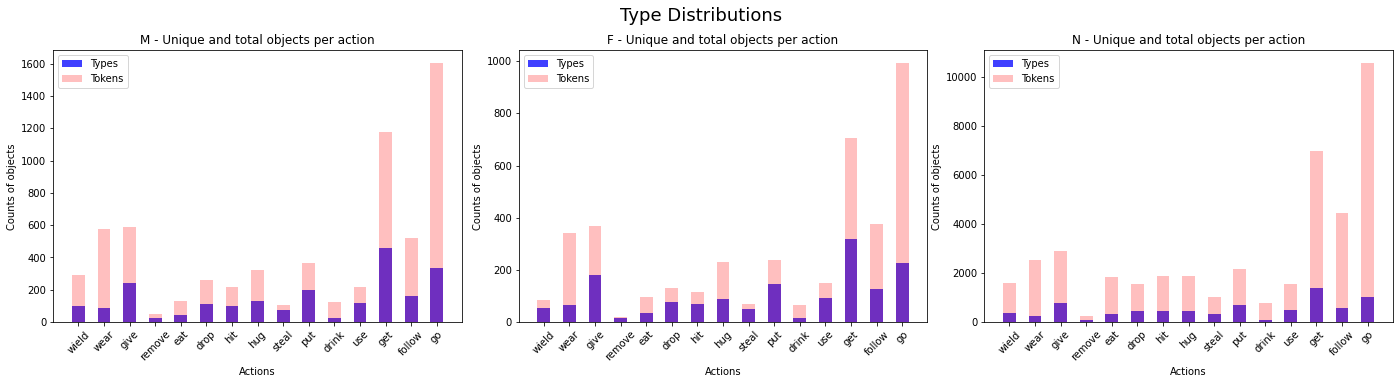

In [ ]:
#@title ##### Plot types, tokens across verbs

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 5))
plt.subplots_adjust(hspace=0.5, wspace=0.14)
fig.suptitle("Type Distributions", fontsize=18, y=1)
mode = "objects" #@param ["objects", "actions"]
do_save = "false" #@param [true, false]
mx = 15 #@param
if mode == "objects":
    ky = "action"
    df = vod_df
else:
    ky = "object"
    df = o2v_df.dropna(axis=0)[:mx]
for ix, (g, ax) in enumerate(zip(["M", "F", "N"], axs.ravel())):
    types = df.apply(lambda x: len(x.values[ix]), axis=1).items()
    tokens = df.apply(lambda x: sum(x.values[ix].values()), axis=1).items()
    labels = df.apply(lambda x: sum(x.values[ix].values()), axis=1).keys()
    barwidth = 0.5
    typebar = ax.bar(*zip(*types), alpha=0.75, color='blue',
                     label="Types", width=barwidth)
    tokbar = ax.bar(*zip(*tokens), alpha=0.25, color='red',
                    label="Tokens", width=barwidth)
    ax.set_xticklabels(labels=labels, rotation=45)
    ax.set_title(f"{g} - Unique and total {mode} per {ky}")
    ax.set_xlabel(f"{ky.title()}s")
    ax.set_ylabel(f"Counts of {mode}")
    ax.legend()
if do_save == "true":
    plt.savefig(f"ttrv_{ky}.png")
plt.show()

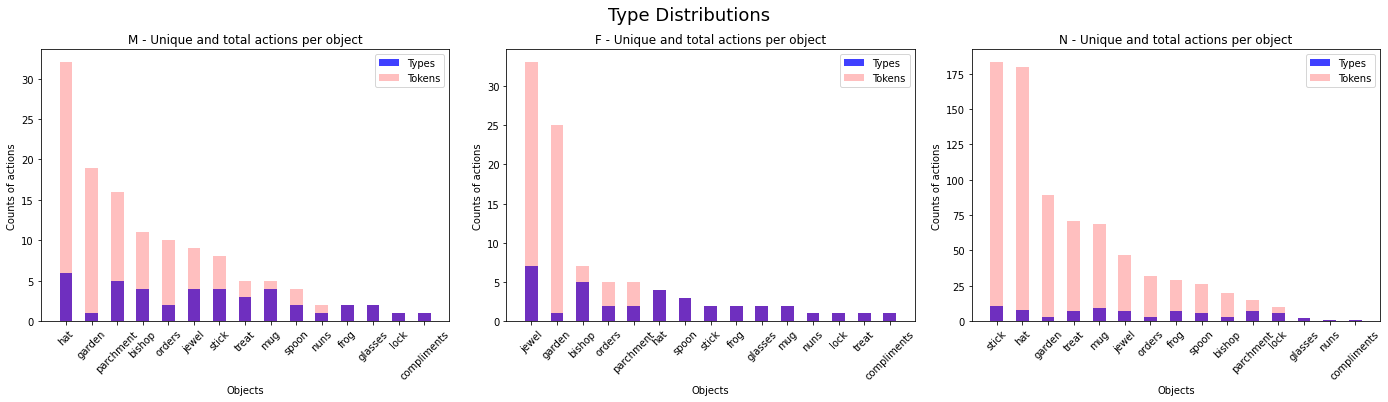

In [ ]:
#@title ##### Plot types, tokens across verbs (sorted)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 5))
plt.subplots_adjust(hspace=0.5, wspace=0.14)
fig.suptitle("Type Distributions", fontsize=18, y=1)
mode = "actions" #@param ["objects", "actions"]
do_save = "true" #@param [true, false]
mx = 15 #@param
if mode == "objects":
    ky = "action"
    df = vod_df
else:
    ky = "object"
    df = o2v_df.dropna(axis=0)[:mx]
for ix, (g, ax) in enumerate(zip(["M", "F", "N"], axs.ravel())):
    test = df.apply(lambda x: sum(x.values[ix].values()), axis=1).sort_values(ascending=False)
    types = df.apply(lambda x: len(x.values[ix]), axis=1).items()
    tokens = df.apply(lambda x: sum(x.values[ix].values()), axis=1).items()
    labels = df.apply(lambda x: sum(x.values[ix].values()), axis=1).keys()
    barwidth = 0.5
    ks = test.keys()
    vs = []
    t = dict(types)
    for l in ks:
        vs.append(t[l])
    types = zip(ks, vs)
    #types = df.apply(lambda x: len(x.values[ix]), axis=1).items()
    tokens = df.apply(lambda x: sum(x.values[ix].values()), axis=1).items()
    typebar = ax.bar(*zip(*types), alpha=0.75, color='blue',
                     label="Types", width=barwidth)
    tokbar = ax.bar(*zip(*test.items()), alpha=0.25, color='red',
                    label="Tokens", width=barwidth)
    ax.set_xticklabels(labels=ks, rotation=45)
    ax.set_title(f"{g} - Unique and total {mode} per {ky}")
    ax.set_xlabel(f"{ky.title()}s")
    ax.set_ylabel(f"Counts of {mode}")
    ax.legend()
if do_save == "true":
    plt.savefig(f"ttrv_{ky}.png")
plt.show()

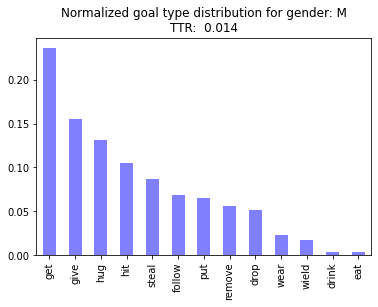

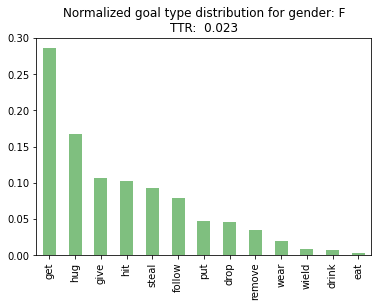

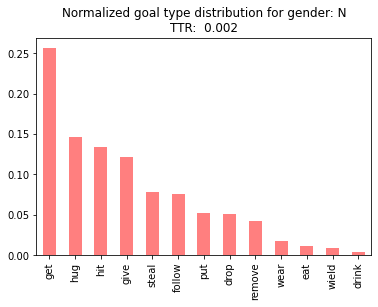

In [ ]:
#@title Goal TTR inspired by [Ammanabrolu et al.](https://aclanthology.org/2022.acl-long.557/) but with goal commands vs. short motivation parsing
for color, g in zip(["blue", "green", "red"], ["M", "F", "N"]):
    l = dfqq_gmn[dfqq_gmn.gender == g].goal.apply(lambda x: x.split()[0]).values.tolist()
    c = Counter(l)
    df = pd.DataFrame(c.items())
    df.index = df.loc[:, 0].values
    df = df.drop(columns=0)
    df = df.sort_values(by=1, ascending=False)
    df.rename(columns={df.columns[0]: 'tokens'}, inplace=True)
    df = df.apply(lambda x: x/x.sum(), axis=0)
    #df = df.apply(lambda x: x/total, axis=0)
    df.plot.bar(color=color, alpha=0.5,
                title=f"Normalized goal type distribution for gender: {g}\nTTR: {len(c.keys())/sum(c.values()): 0.3f}",
                legend=False)
    plt.show()


M sword
# unique actions for sword: 9
Total # of actions for sword: 164
TTR for sword's actions: 0.05

F sword
# unique actions for sword: 6
Total # of actions for sword: 18
TTR for sword's actions: 0.33

N sword
# unique actions for sword: 10
Total # of actions for sword: 626
TTR for sword's actions: 0.02



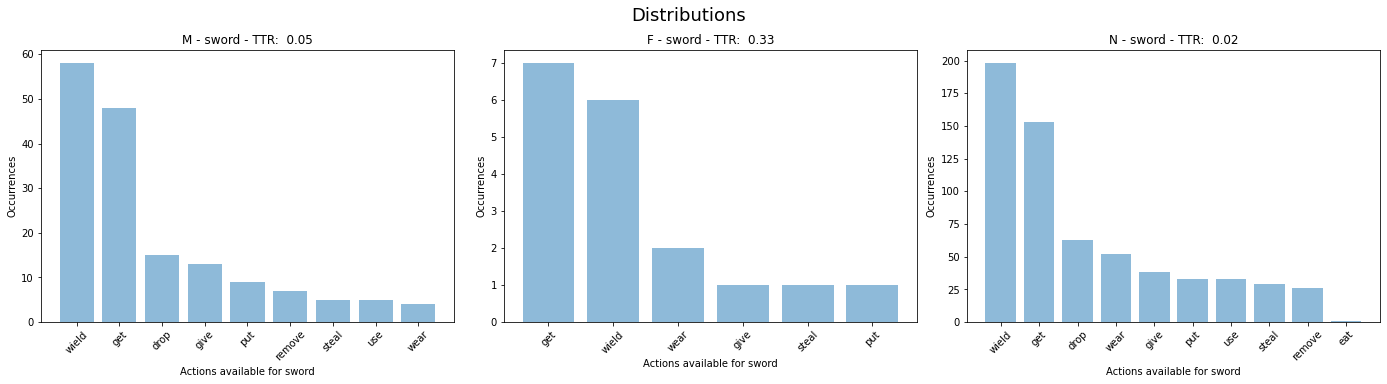

In [ ]:
#@title ##### Get TTR for action/object
k = 15 #@param
do_save = "false" #@param [true, false]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 5))
plt.subplots_adjust(hspace=0.5, wspace=0.12)
fig.suptitle("Distributions", fontsize=18, y=1)
mode = "actions" #@param ["objects", "actions"]
ttr_d = vod if mode == "objects" else o2v
ov = "wield" #@param ['drink','drop','eat','follow','get','give','go','hit','hug','put','remove','steal','use','wear','wield']
av = "sword" #@param
v = ov if mode == "objects" else av
stats_d = {g: {v: {"types": None}, v: {"tokens": None}, v: {"ttr": None}}
               for g in ["M", "F", "N"]}
for g, ax in zip(["M", "F", "N"], axs.ravel()):
    print(g, v)
    types = len(ttr_d[g][v].keys())
    tokens = sum(ttr_d[g][v].values())
    ttr = types/tokens
    stats_d[g][v]["types"] = types
    stats_d[g][v]["tokens"] = tokens
    stats_d[g][v]["TTR"] = ttr
    print(f"# unique {mode} for {v}: {types}")
    print(f"Total # of {mode} for {v}: {tokens}")
    print(f"TTR for {v}'s {mode}: {round(ttr, 2)}\n")
    mc = ttr_d[g][v].most_common(k)
    ax.bar(*zip(*mc), alpha=0.5)
    ax.set_xticklabels(labels=[x[0] for x in mc], rotation=45)
    ax.set_title(f"{g} - {v} - TTR: {ttr: 0.2f}")
    ax.set_ylabel(f"Occurrences")
    ax.set_xlabel(f"{mode.title()} available for {v}")
if do_save == "true":
    plt.savefig(f"objdist_{mode}_{v}.png")
plt.show()

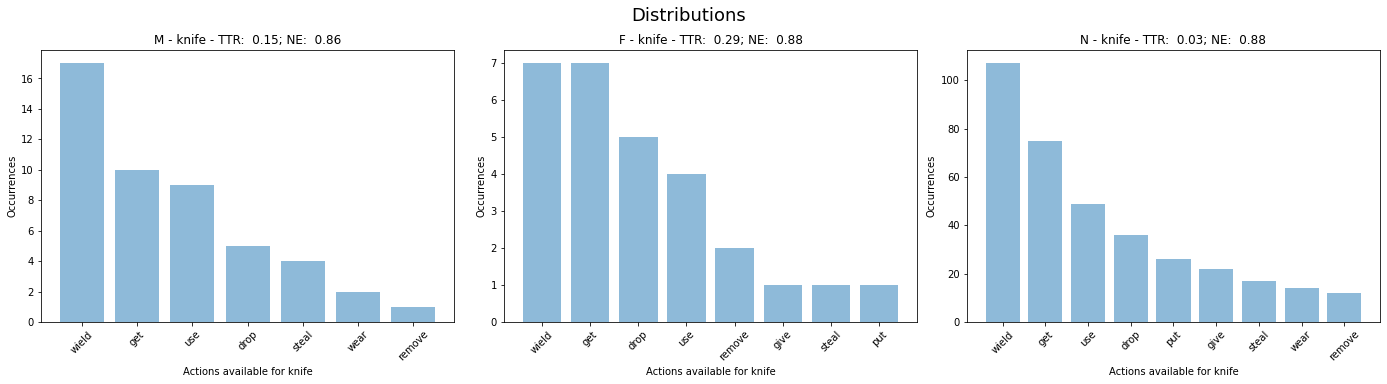

In [ ]:
#@title ##### Get combined TTR, NE
k = 15 #@param
do_save = "false" #@param [true, false]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 5))
plt.subplots_adjust(hspace=0.5, wspace=0.12)
fig.suptitle("Distributions", fontsize=18, y=1)
mode = "actions" #@param ["actions", "objects"]
ttr_d = vod if mode == "objects" else o2v
g = "F" #@param ["M", "F", "N", "all"]
a = "drink" #@param ['drink','drop','eat','follow','get','give','go','hit','hug','put','remove','steal','use','wear','wield']
av = "knife" #@param
v = ov if mode == "objects" else av
base = 2 #@param [0, 2] {type:"raw"}
print_counts = "false" #@param ["true", "false"]
print_counts = False if print_counts == "false" else True

for g, ax in zip(["M", "F", "N"], axs.ravel()):
    #print(g, v)
    types = len(ttr_d[g][v].keys())
    tokens = sum(ttr_d[g][v].values())
    ttr = types/tokens
    result = get_ens(ttr_d, g, v, base, print_counts) # gd, g, a, base - scipy ent already computes p
    if result:
        entrpy, norm_ent, max_n = result
        #print(f"Gender: {g}, Action: {a}")
        #print(f"Normalized (by # of unique arguments of '{a}') entropy: {round(norm_ent, 2)}")
        #print(f"(Ratio of entropy {round(entrpy, 2)} to maximum entropy of {round(max_n, 2)}.)")
        #print("\n")
    #print(f"# unique {mode} for {v}: {types}")
    #print(f"Total # of {mode} for {v}: {tokens}")
    #print(f"TTR for {v}'s {mode}: {round(ttr, 2)}\n")
    mc = ttr_d[g][v].most_common(k)
    ax.bar(*zip(*mc), alpha=0.5)
    ax.set_xticklabels(labels=[x[0] for x in mc], rotation=45)
    ax.set_title(f"{g} - {v} - TTR: {ttr: 0.2f}; NE: {norm_ent: 0.2f}")
    ax.set_ylabel(f"Occurrences")
    ax.set_xlabel(f"{mode.title()} available for {v}")
if do_save == "true":
    plt.savefig(f"objdist_{mode}_{v}.png")
plt.show()

#### 2. Graphs

###### a. Define function to construct graph from dictionary.

In [ ]:
def get_edges(df, g):
    d = df.dropna(axis=0).to_dict()
    edges = []
    for k, countr in d[g].items():
        for ck, w in countr.most_common():
            edges.append((k, ck, {'width': w}))
    return edges

###### b. Visualize objects action is applied to w/ counts, or actions object is afforded.

- ```g``` - gender
- ```s``` - action or object
- ```rng``` - range (top $k$)
- ```freq``` - minimum count

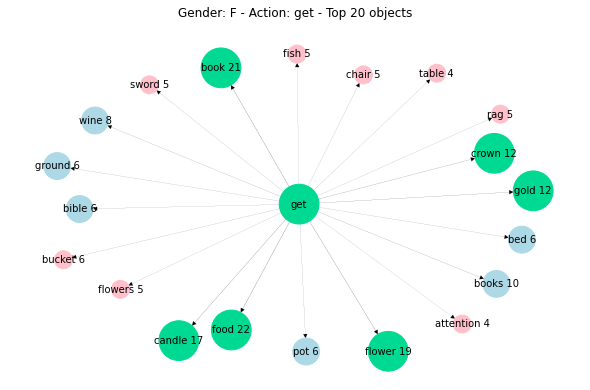

In [ ]:
#@title ###### Select action

g = "F" #@param ["M", "F", "N"]
edges = get_edges(vod_df, g)
s = "get" #@param ['drink','drop','eat','follow','get','give','go','hit','hug','put','remove','steal','use','wear','wield']
rng = 20 #@param {type:"slider", min:5, max:50, step:5}
freq = 6 #@param {type:"slider", min:1, max:10, step:1}
mx = len(vod[g][s].keys())
rng = min(mx, rng)
for six, t in enumerate(edges):
    if t[0] == s:
        break
eix = six+rng
G = nx.MultiDiGraph()
G.add_edges_from(edges[six:eix])
labels = {v: v + f" {wd['width']}" for u, v, wd in edges[six:eix]}
labels[s] = s
d = dict(G.degree)
weights = [wd['width'] for u, v, wd in edges[six:eix]]
weight_d = [(w/sum(weights))+.05 for w in weights]
fig = plt.figure(1, figsize=(8, 5))
nx.draw(G, labels=labels, font_size=10, node_color=['#00D992' if _ <= freq
                                     else "lightblue"
                                        if _ <= freq * 2
                                            else "pink"
                       for _ in range(len(G.nodes()))],
        node_size=[1580 if n <= freq else 720 if n <= freq * 2 else 320
                   for n in range(len(G.nodes()))], # or remove range and freq, use len(n) * 320
        with_labels=True, width=weight_d)
plt.title(f"Gender: {g} - Action: {s} - Top {rng} objects")
plt.savefig(f"{g}_{s}_graph_top_{rng}_freq_{freq}.png")
plt.draw()

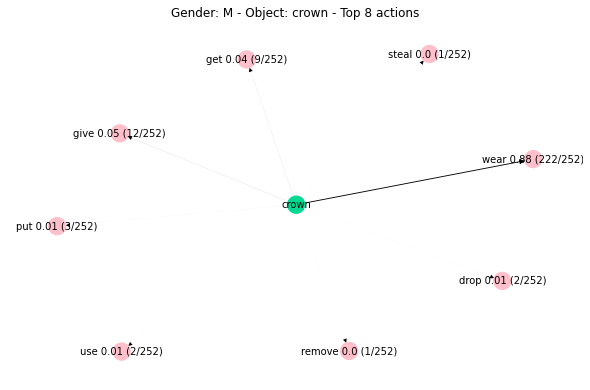

In [ ]:
#@title ###### Select object

g = "M" #@param ["M", "F", "N"]
edges = get_edges(o2v_df, g)
s = "crown" #@param
try:
    mx = len(o2v[g][s].keys())
    rng = 14 #@param {type:"slider", min:1, max:14, step:1}
    freq = 0.2 #@param {type:"slider", min:0.01, max:1.0, step:0.01}
    rng = min(mx, rng)
    for six, t in enumerate(edges):
        if t[0] == s:
            break
    eix = six+rng
    G = nx.MultiDiGraph()
    G.add_edges_from(edges[six:eix])
    weights = [wd['width'] for u, v, wd in edges[six:eix]]
    weight_d = [(w/sum(weights)) for w in weights]
    labels = {v: v + f" {round((wd['width']/sum(weights)), 2)} ({wd['width']}/{sum(weights)})" for u, v, wd in edges[six:eix]}
    labels[s] = s
    d = dict(G.degree)
    fig = plt.figure(1, figsize=(8, 5))
    nx.draw(G, labels=labels, font_size=10, node_color=['#00D992' if _ <= freq
                                        else "lightblue"
                                            if _ <= freq * 2
                                                else "pink"
                        for _ in range(len(G.nodes()))],
            with_labels=True, width=weight_d)
    plt.title(f"Gender: {g} - Object: {s} - Top {rng} actions")
    plt.draw()
except KeyError:
    print(f"Object not used by {g} characters, try another.")
plt.savefig(f"{g}_{s}_graph_top_{rng}_freq_{freq}.png")

# III. Entropy
Measure normalized entropy of verb-object pairs.

#### 0. Set path to data folder to use in notebook.

In [ ]:
DATA_PTH = "/../content/drive/MyDrive/data/light_data/"

#### 1. Imports, load verb-object and object-verb dictionaries.

In [ ]:
from scipy.stats import entropy
import pandas as pd
import numpy as np

#### 2. Run to choose data split for loading/saving and run cell:

In [ ]:
split = "train" #@param ["train", "dev", "test"]
gen = "false" #@param ["true", "false"]
gnder = "all_subset" #@param ["all_subset", "all", "m", "f", "n", "m_subset"]
gnsd = "42" #@param [42, 7304, 7696]
gnmd = "quest_sampl" #@param ["quest_sampl", "quest_beaml"]

#### 3. Load dataframes, convert to dictionaries. Choose whether to use original data or generated with gender annotations per split.

In [ ]:
if gen == "true":
    vod_df = pd.read_pickle(f"{DATA_PTH}vod_df_genderated_{split}_simplified_{gnder}_{gnmd}_{gnsd}.pkl")
    o2v_df = pd.read_pickle(f"{DATA_PTH}o2v_df_genderated_{split}_{gnder}_{gnmd}_{gnsd}.pkl")
else:
    vod_df = pd.read_pickle(f"{DATA_PTH}vod_df_simplified.pkl")
    o2v_df = pd.read_pickle(f"{DATA_PTH}o2v_df.pkl")

vod = vod_df.to_dict()
o2v = o2v_df.to_dict()
o2v2 = o2v_df.dropna(axis=0).to_dict()

#### 4. Define function to get normalized entropy of objects paired with given action.

In [ ]:
gs = ["M", "F", "N"]

def get_ens(d, g, a, base, prnt):
    """Given action-object counts, computes
        and returns entropy.
    """
    try:
        res = list(d[g][a].values())
    except KeyError:
        print(f"{a} not in dictionary for {g}.")
        return None
    if prnt:
        for k, v in d[g][a].items():
            print(k, v) # e.g. wine 10, ale 4
    base = None if base == 0 else base
    if base == 2:
        lg = np.log2
    else:
        lg = np.log
    entrpy = entropy(res, base=base) # Normalizes counts of verb-object pairing
    max_n = lg(len(res), where=len(res) > 0)
    norm_ent = entrpy/max_n if max_n > 0 else 0.0
    return entrpy, norm_ent, max_n

def get_entropy(res, base):
    base = None if base == 0 else base
    if base == 2:
        lg = np.log2
    else:
        lg = np.log
    entrpy = entropy(res, base=base) # Normalizes counts of verb-object pairing
    max_n = lg(len(res), where=len(res) > 0)
    norm_ent = entrpy/max_n if max_n > 0 else 0.0
    return entrpy, norm_ent, max_n

#### 5. Select all or specific gender ```g```, action ```a``` and logarithmic base ```base``` (0 is natural log), run cell to get entropy of verb-object pairings, e.g. of possible objects the action is applied to.

In [ ]:
#@title Entropy of given gender, action

g = "F" #@param ["M", "F", "N", "all"]
a = "wield" #@param ['drink','drop','eat','follow','get','give','go','hit','hug','put','remove','steal','use','wear','wield']
base = 2 #@param [0, 2] {type:"raw"}
print_counts = "false" #@param ["true", "false"]
print_counts = False if print_counts == "false" else True
if g == "all":
    gs = ["M", "F", "N"]
else:
    gs = [g]
for g in gs:
    result = get_ens(vod, g, a, base, print_counts) # gd, g, a, base - scipy ent already computes p
    if result:
        entrpy, norm_ent, max_n = result
        print(f"Gender: {g}, Action: {a}")
        print(f"Normalized (by # of unique arguments of '{a}') entropy: {round(norm_ent, 2)}")
        print(f"(Ratio of entropy {round(entrpy, 2)} to maximum entropy of {round(max_n, 2)}.)")
        print("\n")

Gender: F, Action: wield
Normalized (by # of unique arguments of 'wield') entropy: 0.94
(Ratio of entropy 5.37 to maximum entropy of 5.73.)




#### 6. Select all or specific gender ```g```, object ```o``` and logarithmic base ```base``` (0 is natural log), run cell to get entropy of verb-object pairings for an object, e.g. commands afforded by crown.

In [ ]:
#@title Entropy of given gender, object

g = "all" #@param ["M", "F", "N", "all"]
o = "crown" #@param
base = 2 #@param [0, 2] {type:"raw"}
print_counts = "false" #@param ["true", "false"]
print_counts = False if print_counts == "false" else True

if g == "all":
    gs = ["M", "F", "N"]
else:
    gs = [g]
for g in gs:
    result = get_ens(o2v2, g, o, base, print_counts) # gd, g, a, base - scipy ent already computes p
    if result:
        entrpy, norm_ent, max_n = result
        print(f"Gender: {g}, Object: {o}")
        print(f"Normalized (by # of unique actions for '{o}') entropy: {round(norm_ent, 2)}")
        print(f"(Ratio of entropy {round(entrpy, 2)} to maximum entropy of {round(max_n, 2)}.)")
        print("\n")

Gender: M, Object: crown
Normalized (by # of unique actions for 'crown') entropy: 0.74
(Ratio of entropy 2.07 to maximum entropy of 2.81.)


Gender: F, Object: crown
Normalized (by # of unique actions for 'crown') entropy: 0.9
(Ratio of entropy 2.09 to maximum entropy of 2.32.)


Gender: N, Object: crown
Normalized (by # of unique actions for 'crown') entropy: 0.91
(Ratio of entropy 2.57 to maximum entropy of 2.81.)




#### 7. Save normalized entropy results

##### a. Collect normalized entropies for all actions/objects.

In [ ]:
etyp = "affordant_objects" #@param ['affordant_objects', 'object_affordances'] {'type': 'string'}
svent = "false" #@param ["true", "false"]
gen = "true" #@param ["true", "false"]
if gen == "true":
    vod_df = pd.read_pickle(f"{DATA_PTH}vod_df_genderated_{split}_simplified_{gnder}_{gnmd}_{gnsd}.pkl")
    o2v_df = pd.read_pickle(f"{DATA_PTH}o2v_df_genderated_{split}_{gnder}_{gnmd}_{gnsd}.pkl")
else:
    vod_df = pd.read_pickle(f"{DATA_PTH}vod_df_simplified.pkl")
    o2v_df = pd.read_pickle(f"{DATA_PTH}o2v_df.pkl")

vod = vod_df.to_dict()
o2v = o2v_df.to_dict()
o2v2 = o2v_df.dropna(axis=0).to_dict()
gs = ["M", "F", "N"]
if etyp == 'affordant_objects':
    print("Normalized entropy for probabilities of each action paired with applicable objects.")
    dd = vod
else:
    print("Normalized entropy for probabilities of each object's commands.")
    dd = o2v2
results = dict()
for g in gs:
    results[g] = list(map(lambda k: get_ens(dd, g, k, 2, False)[1], dd[g].keys()))
resdf = pd.DataFrame(results)
if svent == "true":
    if gen == "true":
        resdf.to_csv(f"{DATA_PTH}norment_all_genderated_{split}_{etyp}_{gnder}_{gnmd}_{gnsd}.csv", index=False)
    else:
        resdf.to_csv(f"{DATA_PTH}norment_all_{etyp}.csv", index=False)

Normalized entropy for probabilities of each action paired with applicable objects.


In [ ]:
df = eq_df(resdf)
get_res(df.M.values, df.F.values, 0.05)

In [ ]:
#@title Bulk compute generated entropies

savent = "true" #@param ["true", "false"]
gs = ["M", "F", "N"]
for gnmd in ["quest_sampl", "quest_beaml"]:
    for gnsd in [42, 7304, 7696]:
        for split in ["train", "dev", "test"]:
            for gnder in ["all", "all_subset", "m", "m_subset", "n_subset", "f", "n"]:
                vod_df = pd.read_pickle(f"{DATA_PTH}vod_df_genderated_{split}_simplified_{gnder}_{gnmd}_{gnsd}.pkl")
                o2v_df = pd.read_pickle(f"{DATA_PTH}o2v_df_genderated_{split}_{gnder}_{gnmd}_{gnsd}.pkl")
                vod = vod_df.to_dict()
                o2v = o2v_df.to_dict()
                o2v2 = o2v_df.dropna(axis=0).to_dict()

                for etyp in ['affordant_objects', 'object_affordances']:
                    if etyp == 'affordant_objects':
                        #print("Normalized entropy for probabilities of each action paired with applicable objects.")
                        dd = vod
                    else:
                        #print("Normalized entropy for probabilities of each object's commands.")
                        dd = o2v2
                    results = dict()
                    for g in gs:
                        results[g] = list(map(lambda k: get_ens(dd, g, k, 2, False)[1], dd[g].keys()))
                    resdf = pd.DataFrame(results)
                    if savent == "true":
                        resdf.to_csv(f"{DATA_PTH}norment_all_genderated_{split}_{etyp}_{gnder}_{gnmd}_{gnsd}.csv", index=False)

##### c. Load, format, test saved normalized entropies

In [ ]:
#@title Load individual

etyp = "affordant_objects" #@param ['affordant_objects', 'object_affordances'] {'type': 'string'}
split = "train" #@param ["train", "dev", "test"]
gen = "false" #@param ["true", "false"]
gnder = "all_subset" #@param ["all_subset", "all", "m", "f", "n", "m_subset", "n_subset"]
gnsd = "7304" #@param [42, 7304, 7696]
gnmd = "quest_sampl" #@param ["quest_sampl", "quest_beaml"]
if gen == "true":
    resdf = pd.read_csv(f"{DATA_PTH}norment_all_genderated_{split}_{etyp}_{gnder}_{gnmd}_{gnsd}.csv")
else:
    resdf = pd.read_csv(f"{DATA_PTH}norment_all_{etyp}.csv")

In [ ]:
#@title Bulk load NE
gnmd = "quest_sampl" #@param ["quest_sampl", "quest_beam"]
all_ed = dict()
for gnder in ["all", "all_subset", "m", "m_subset", "f", "n", "n_subset"]:
    esplits = dict()
    for split in ["train", "dev", "test"]:
        esplits[split] = []
        for etyp in ['affordant_objects', 'object_affordances']:
            if etyp == 'affordant_objects':
                dd = vod
            else:
                dd = o2v
            resdfa = pd.DataFrame()
            for gnsd in [42, 7304, 7696]:
                resdf = pd.read_csv(f"{DATA_PTH}norment_all_genderated_{split}_{etyp}_{gnder}_{gnmd}_{gnsd}.csv")
                resdfa = pd.concat([resdfa, resdf.mean()], axis=1)
            resdfa.columns = ["42", "7304", "7696"]
            esplits[split].append(round(resdfa.mean(axis=1), 3))
    all_ed[gnder] = esplits


In [ ]:
#@title Format for LaTeX
new_all_e = dict()
for gnder in all_ed.keys():
    splits_d = dict()
    for split in ["train", "dev", "test"]:
        split_df = pd.DataFrame(all_ed[gnder][split]).T
        split_df.columns = ["ao", "oa"]
        split_df = split_df.T
        splits_d[split] = split_df

    res = pd.concat(splits_d.values(), axis=0, keys=splits_d.keys())
    new_all_e[gnder] = res

In [ ]:
new_all_ef = pd.concat(new_all_e.values(), axis=1, keys=new_all_e.keys())

In [ ]:
# new_all_ef.to_csv(f"{DATA_PTH}generated_ent.csv", index_label=new_all_ef.index.tolist())

In [ ]:
test_def = pd.read_csv(f"{DATA_PTH}generated_ent.csv", header=[0, 2], index_col=[0, 1])

In [ ]:
test_def = test_def.iloc[:, :21]
test_def.columns = new_all_ef.columns

In [ ]:
print(test_def.to_latex())

In [ ]:
#@title Bulk compute sig, effect size

splits = ["train", "dev", "test"]
gnmd = "quest_sampl" #@param ["quest_sampl", "quest_beam"]
all_ed = dict()
for gnder in ["all", "all_subset", "m", "m_subset", "f", "n", "n_subset"]:
    all_ed[gnder] = dict()
    esplits = dict()
    for split in splits:
        all_ed[gnder][split] = dict()
        esplits[split] = dict()
        for etyp in ['affordant_objects', 'object_affordances']:
            all_ed[gnder][split] = dict()
            esplits[split][etyp] = {"A": [], "B": []}
            '''if etyp == 'affordant_objects':
                dd = vod
            else:
                dd = o2v'''
            resdfa = pd.DataFrame()
            for gnsd in [42, 7304, 7696]:
                resdf = pd.read_csv(f"{DATA_PTH}norment_all_genderated_{split}_{etyp}_{gnder}_{gnmd}_{gnsd}.csv")
                df = eq_df(resdf)
                a = df["M"].values
                b = df["F"].values
                esplits[split][etyp]["A"].append((gnsd, a))
                esplits[split][etyp]["B"].append((gnsd, b))
        for typ, A, B in [("affordant_objects", esplits[split]["affordant_objects"]["A"],
                            esplits[split]["affordant_objects"]["B"]),
                            ("object_affordances", esplits[split]["object_affordances"]["A"],
                            esplits[split]["object_affordances"]["B"])]:
            alt = "less"
            pairs = zip(A, B)
            all_ed[gnder][split][typ] = dict()
            for a, b in pairs:
                sda, a = a
                sdb, b = b
                if sda == sdb:
                    with warnings.catch_warnings():
                        warnings.filterwarnings(category=RuntimeWarning,
                                                action='ignore',
                                                message='overflow encountered in double_scalars')
                        res = get_res(a, b, alpha=0.05, alt=alt)
                        if not res["sig"]:
                            res = get_res(a, b, alpha=0.05, alt='greater')
                        if not res["sig"]:
                            res = get_res(a, b, alpha=0.05, alt='two-sided')
                        all_ed[gnder][split][typ][sda] = res

In [ ]:
# np.save(f'{DATA_PTH}gender_ne_sigs.npy', all_ed)

In [ ]:
all_ed2 = np.load(f'{DATA_PTH}gender_ne_sigs.npy', allow_pickle='TRUE').item()

In [ ]:
keyys = ["ne ao", "ne oa"]

In [ ]:
#@title Format sig, effect size results

new_all_d = dict()
for gnder in all_ed.keys():
    splits_d = dict()
    for split in ["train", "dev", "test"]:
        split_df = pd.DataFrame(all_ed[gnder][split])
        split_df.columns = keyys
        def reps(x):
            # ensure all are M < F
            s = x["alt"]
            if "greater" in s or ("two-sided" in s and x["cles"] != 0):
                sys.exit()
            if x["cles"] == 0:
                return ""
            else:
                return s.replace("less", "<").replace("greater", ">").replace("two-sided", "!=")
        split_df = split_df.applymap(lambda x: str(x["sig"] * np.round(x["cles"], 2)) + reps(x))
        split_df = split_df.T
        splits_d[split] = split_df

    res = pd.concat(splits_d.values(), axis=0, keys=splits_d.keys())
    new_all_d[gnder] = res

In [ ]:
df = pd.concat(new_all_d.values(), axis=1, keys=new_all_d.keys())
df = df.mask(df=="0").fillna("--")

In [ ]:
print(df.to_latex())

##### d. Display averaged results per gender.

In [ ]:
df = resdf[resdf.M != 0]
df = df[df.F != 0]
get_res(df.M.values, df.F.values, 0.05, "less")

# IV. Surprisal (Affordance Sensitivity)

#### a. Imports, dependencies

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
!pip install transformers sentencepiece datasets &> /dev/null

In [ ]:
from transformers import (T5TokenizerFast as T5Tokenizer, T5ForConditionalGeneration,
                          BartTokenizer, BartForConditionalGeneration)
from transformers import (AutoTokenizer, DataCollatorWithPadding, Seq2SeqTrainer,
                          DataCollatorForSeq2Seq, Seq2SeqTrainingArguments,
                          Trainer, TrainingArguments)

from datasets import load_dataset, DatasetDict

from datasets import load_from_disk

In [ ]:
!pip install minicons &> /dev/null # https://pypi.org/project/minicons/

In [ ]:
from minicons import scorer

In [ ]:
from collections import defaultdict
import re, sys
import random, numpy as np, torch
import pandas as pd
from collections import Counter

In [ ]:
DATA_PTH = f"/../content/drive/MyDrive/data/light_data/"

In [ ]:
from google.colab import data_table

data_table.enable_dataframe_formatter()
data_table.DataTable.num_rows_per_page = 10


In [ ]:
import ipywidgets as widgets
from ipywidgets import (interact, interactive,
                        interactive_output,
                        fixed, interact_manual)
from IPython.display import display, clear_output

In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

seed = 42
set_seed(seed)

#### b. Load model, tokenizer for encodings

```sel``` chooses BART, T5, or fine-tuned versions thereof. ```sz``` choose between base-size or large. ```g``` selects all genders or male, female, or gender-neutral.

In [ ]:
#@title ##### Primary model, tokenizer selection

sel = "bart" #@param ["bart", "t5", "bart_custom", "t5_custom"]
sz = "base" #@param ["base", "large"]
g = "All (Subset)" #@param ["All", "All (Subset)", "Male", "Female", "Neutral", "Male (Subset)", "Neutral (Subset)"]
gd = {"Male": "m", "Female": "f", "Neutral": "n", "All": "all", "Male (Subset)": "m_subset",
      "All (Subset)": "all_subset", "Neutral (Subset)": "n_subset"}
g = gd[g]
sd = "42" #@param [42, 7304, 7696]
cd = {"all": 1640, "m": 205, "f": 180, "n": 1305,
      "m_subset": 180, "all_subset": 180, "n_subset": 180}
cp = cd[g]
pth = widgets.Text(f"{DATA_PTH}models/quest_model_{g}_{sd}/checkpoint-{cp}").value
display(pth)

if pth or "custom" not in sel:
    mt = {"t5": (f"t5-{sz}", (T5Tokenizer, T5ForConditionalGeneration)),
        "bart": (f"facebook/bart-{sz}", (BartTokenizer, BartForConditionalGeneration)),
        "bart_custom": (f"facebook/bart-{sz}", (BartTokenizer, BartForConditionalGeneration)),
        "t5_custom": (f"t5-{sz}", (T5Tokenizer, T5ForConditionalGeneration))}

    if sel in ["t5", "bart"]:
        print(f"Using base {sel.upper()}.")
        tokenizer = mt[sel][1][0].from_pretrained(f"{mt[sel][0]}")
        modelnm = f"{mt[sel][0]}"
    else:
        if "t5" in sel:
            tpth = "t5-base"
        elif "bart_" in sel:
            tpth = "facebook/bart-base"
        tokenizer = mt[sel][1][0].from_pretrained(f"{tpth}")
        modelnm = pth
    #tokenizer.pad_token = tokenizer.eos_token

##### Load data for prompts

In [ ]:
vod_df = pd.read_pickle(f"{DATA_PTH}vod_df_simplified.pkl")
o2v_df = pd.read_pickle(f"{DATA_PTH}o2v_df.pkl")

vod = vod_df.to_dict()
o2v = o2v_df.to_dict()
o2v2 = o2v_df.dropna(axis=0).to_dict()

In [ ]:
dfqq = pd.read_pickle(f"{DATA_PTH}dfqq_gmn.pkl")

##### 1. Load splits, tokenize

In [ ]:
qtrain_dev_test_dataset = load_from_disk(f"{DATA_PTH}light_dataset")

#### c. Setup, compute surprisals, save, plot

In [ ]:
dvc = "cuda" #@param ["cuda", "cpu"]

In [ ]:
#@title Setup (tokenizer, definitions)
tokenizer = BartTokenizer.from_pretrained(f"facebook/bart-base")
vset = {'drink','drop','eat','follow','get','give',
        'go','hit','hug','put','remove','steal',
        'use','wear','wield'}
toks = ["wield", "drink", "hug", "steal"]
for v in vset:
    for tok in tokenizer(v)["input_ids"][1:-1]:
        toks.append(tokenizer.decode(tok))
def get_ind_res(ind_res):
    """Get object surprisal, averaged over subword tokens if necessary."""
    ind_toks = [i[0] for i in ind_res]
    ix = ind_toks.index("-")+1
    six = 0
    if ind_toks.count("-") >= 2:
        sind_toks = ind_toks[ix:]
        six = sind_toks.index("-")+1
    ind_res = ind_res[ix+six:-1]
    if ind_res[0][0] in toks:
        if (ind_res[0][0] == "h" and ind_res[1][0] == "ug"
            or ind_res[0][0] == "dr" and ind_res[1][0] == "ink"
            or ind_res[0][0] == "st" and ind_res[1][0] == "eal"
            or ind_res[0][0] == "w" and ind_res[1][0] == "ield"):
            res = np.mean([v for i, v in ind_res[2:]])
        else:
            res = np.mean([v for i, v in ind_res[1:]])
    else:
        print(ind_res)
        sys.exit()
    return(res)

In [ ]:
#@title Setup prompts
topk = 5 #@param
clsms_main = {g: [] for g in ["M", "F", "N"]}
dfqq_gmn = pd.read_pickle(f"{DATA_PTH}dfqq_gmn.pkl") # Contains additional columns listing entities, preserves types
source_df = dfqq_gmn.loc[:, ["gender", "clsm", "character", "location", "short_motivation", "quest", "questl"]]
def remove_the(x):
    x["character"] = x["character"].replace("The The ", "The ").replace("The A ", "A ")
    x["location"] = x["location"].replace("The The ", "The ").replace("The A ", "A ")
    x["clsm"] = x["clsm"].replace("The The ", "The ").replace("The A ", "A ")
    return x
sdf = source_df.apply(remove_the, axis=1)

for clsmg in ["M", "F", "N"]:
    sorted_df = sdf[sdf.gender == clsmg].groupby(['character',
                        'location']).count().reset_index().sort_values(['clsm'],
                                                                        ascending=False)
    characters = []
    locations = []
    for char in sorted_df.character.values.tolist():
        if char not in characters and len(characters) < topk:
            characters.append(char)


    for loc in sorted_df.location.values.tolist():
        if loc not in locations and len(locations) < topk:
            locations.append(loc)

    for char in characters:
        for loc in locations:
            c = char
            l = loc
            context = f"{char} - {loc}"
            clsms_main[clsmg].append(context)

Afforded:

In [ ]:
commands_d = dict()
for gnd in ["M", "F", "N"]:
    commandss = dict()
    vgnd = vod[gnd]
    for action in vgnd.keys():
        commands = []
        for obj in vgnd[action].keys(): #objects:
            if vgnd[action][obj] > 0:
                    commands.append(f"{action} {obj}")
        commandss[action] = commands
    commands_d[gnd] = commandss

Nonafforded:

In [ ]:
a_na_d = {gnd: {action: dict(filter(lambda x: x[-1] > 0, sorted(list(zip(vod[gnd][action].keys(),
                map(lambda x: np.round(x/sum(vod[gnd][action].values()) * 100, 3),
                    vod[gnd][action].values()))),
       key=lambda x: -x[-1]))) for action in vset}
 for gnd in ["M", "F", "N"]}

In [ ]:
#@title Bulk compute models' surprisals for afforded vs. nonafforded
res_sds = dict()
mchars = list(set([s.split(" - ")[0] for s in clsms_main["M"]]))
mprompts = clsms_main["M"]
fchars = list(set([s.split(" - ")[0] for s in clsms_main["F"]]))
fprompts = clsms_main["F"]
prompt_pairs = list(zip(mprompts, fprompts))
for gen_sd in [42, 7304, 7696]:
    set_seed(gen_sd)
    cd = {"base": 0, "all": 1640, "m": 205, "f": 180, "n": 1305,
          "m_subset": 180, "n_subset": 180, "all_subset": 180}
    print(f"Set seed to {gen_sd}.")
    res_gs = dict()
    for g in cd.keys():
        results = dict()
        cp = cd[g.lower()]
        if g == "base":
            modelnm = f"facebook/bart-base"
        else:
            modelnm = f"{DATA_PTH}models/quest_model_{g.lower()}_{gen_sd}/checkpoint-{cp}"
        print(modelnm)
        s2s_model = scorer.Seq2SeqScorer(modelnm, dvc)
        res_ana = dict()
        for action in vset:
            m_items = [cmd for cmd in commands_d["M"][action]
                       if a_na_d["M"][action].get(cmd.split()[-1], 0) > a_na_d["F"][action].get(cmd.split()[-1], 0)] # afforded M, nonafforded F
            f_items = [cmd for cmd in commands_d["F"][action]
                       if a_na_d["F"][action].get(cmd.split()[-1], 0) > a_na_d["M"][action].get(cmd.split()[-1], 0)] # afforded F, nonafforded M
            res_ana[action] = dict()
            for aff, items in [("MA", m_items), ("FA", f_items)]:
                msurp = []
                fsurp = []
                for cmd in items: # afforded male/nonafforded female first, then vice versa
                    commands = []
                    for pair in prompt_pairs: # create pair of m/f prompts for afforded items
                        for s in pair:
                            prompt = f"{s} - {cmd}"
                            commands.append(prompt)
                    # get cmd surprisal for afforded vs. nonafforded by gender
                    res = list(map(get_ind_res,
                                    s2s_model.token_score(commands,
                                                        surprisal = True,
                                                        base_two = True)))
                    msurp.append(res[0]) # surprisal for gender with afforded cmd for that gender
                    fsurp.append(res[1]) # surprisal for opposite gender with nonafforded cmd for that opposite gender
                res_ana[action][aff] = [msurp, fsurp] # for averaging the pairs of surprisals for condition w/ np.mean
        res_gs[g] = res_ana
        del s2s_model
    res_sds[gen_sd] = res_gs


Load/save:

In [ ]:
# np.save(f'{DATA_PTH}surprisals_mfana2.npy', res_sds)

In [ ]:
res_sds = np.load(f'{DATA_PTH}surprisals_mfana2.npy', allow_pickle='TRUE').item()

###### Display:

In [ ]:
cd = {"base": 0, "all": 1640, "m": 205, "f": 180, "n": 1305,
          "m_subset": 180, "n_subset": 180, "all_subset": 180}
vset = {'drink','drop','eat','follow','get','give',
'go','hit','hug','put','remove','steal',
'use','wear','wield'}

In [ ]:
res_d = dict()
for mg in cd.keys():
    s_d = {a: dict() for a in vset}
    for sd in [42, 7304, 7696]:
        for a, vs in res_sds[sd][mg].items():
            a_d = dict()
            for k, v in vs.items():
                a_d[k] = []
                for surp in v:
                    a_d[k].append(np.mean(surp))
                s_d[a][k] = [np.mean(a_d[k][0]), np.mean(a_d[k][1])]
    res_d[mg] = s_d

In [ ]:
verb = "wear" #@param
mafa = "FA" #@param ["MA", "FA"]
for mg in cd.keys():
    print(mg, mafa, 'afforded: ',
            np.round(res_d[mg][verb][mafa][0], 3),
            'nonafforded: ',
            np.round(res_d[mg][verb][mafa][1], 3))

base FA afforded:  24.872 nonafforded:  24.764
all FA afforded:  19.384 nonafforded:  19.668
m FA afforded:  18.406 nonafforded:  18.601
f FA afforded:  17.517 nonafforded:  17.549
n FA afforded:  18.898 nonafforded:  19.721
m_subset FA afforded:  18.395 nonafforded:  18.349
n_subset FA afforded:  18.12 nonafforded:  18.589
all_subset FA afforded:  18.1 nonafforded:  18.515


In [ ]:
verb = "drop" #@param
for mg in cd.keys():
    for g in ["M", "F", "N"]:
        print(mg, g, res_d[mg][g][verb])

    print(mg, "MFR: ", round(res_d[mg]["M"][verb]/res_d[mg]["F"][verb], 3))

In [ ]:
verb = "remove" #@param
for mg in cd.keys():
    for g in ["M", "F", "N"]:
        print(mg, g, res_d[mg][g][verb])

    print(mg, "MFR: ", round(res_d[mg]["M"][verb]/res_d[mg]["F"][verb], 3))

###### Plot

In [ ]:
import matplotlib.pyplot as plt

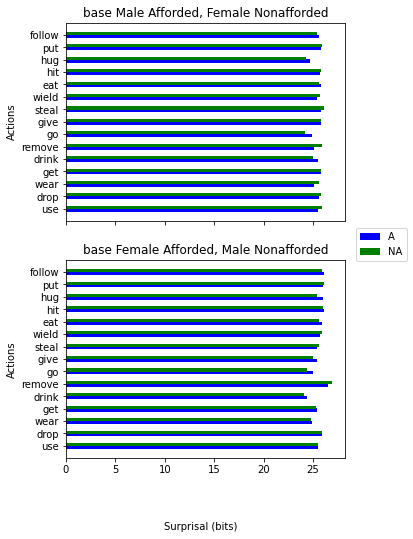

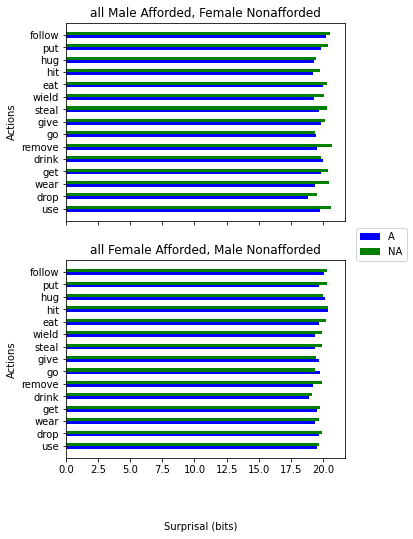

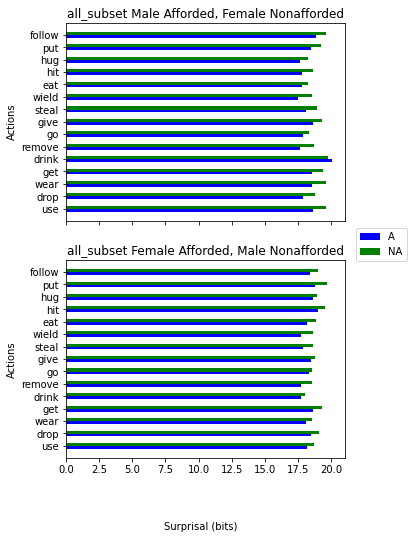

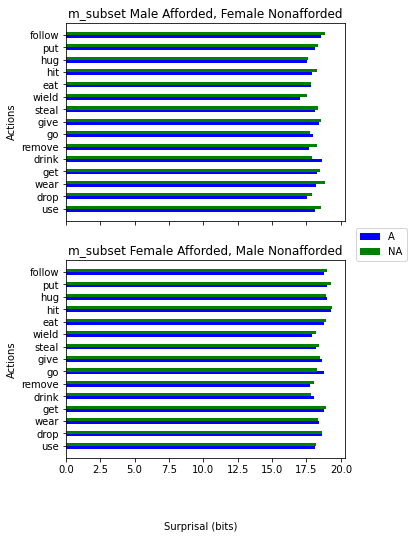

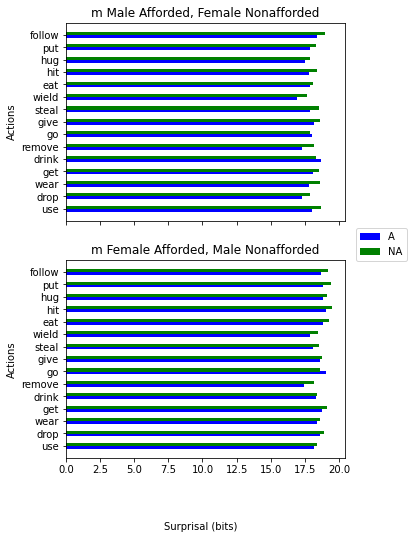

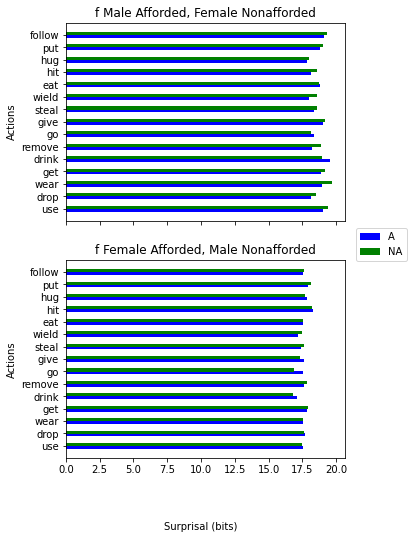

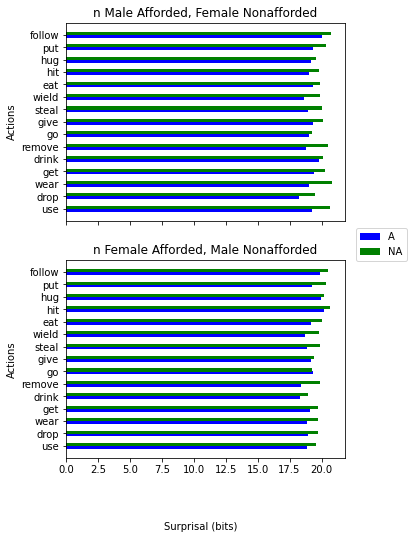

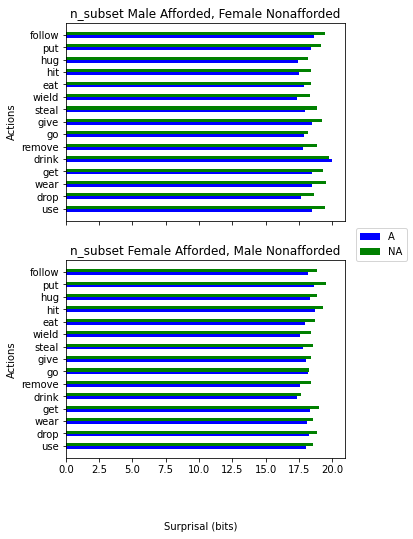

In [ ]:
#@title Experimental bulk plotting (first load res_sds, get res_d)
for mg in ["base", "all", "all_subset", "m_subset", "m", "f", "n", "n_subset"]:
    fig, axs = plt.subplots(2, 1, figsize=(5, 8), sharey=True, sharex=True)
    for ix, ax in enumerate(axs):
        if ix == 0:
            lab = "MA"
        else:
            lab = "FA"
        keys = [key for key in res_d[mg].keys()]
        values = [d[lab] for d in res_d[mg].values()]
        ax.barh(np.arange(len(keys)) - 0.11, [value[0] for value in values], 0.25,
            color='b', align='center')
        ax.barh(np.arange(len(keys)) + 0.11,
            [value[1] for value in values], 0.25,
            color='g', align='center')
        if ix == 0:
            title = f"{mg} Male Afforded, Female Nonafforded"
        else:
            title = f"{mg} Female Afforded, Male Nonafforded"
        ax.set_title(f"{title}")
        ax.set_yticklabels(keys)
        ax.set_yticks(np.arange(len(keys)))

    for ax in axs.flat:
        ax.set(ylabel='Actions')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

    fig.text(0.5, 0, 'Surprisal (bits)', ha='center')
    plt.legend(["A", "NA"], loc='best',
            bbox_to_anchor=(0.74, 0.69, 0.5, 0.5))

    plt.show()


#### d. Significance

In [ ]:
from itertools import product

In [ ]:
#@title Sig test for all seed combinations
# alpha w/ bonferroni
afforded_g = "MA" #@param ["MA", "FA"]
models = ['base', 'All', 'All_subset', 'M', 'M_subset', 'F', 'N', 'N_subset']
m_d = dict()
for model in models:
    print(model)
    model = model.lower()
    A = []
    B = []
    for sd in [42, 7304, 7696]:
        if model == "base":
            sda = 42
        else:
            sda = sd
        ma_all = []
        fna_all = []
        for action, mafa in res_sds[sda][model].items():
            ma_all.extend(mafa[f"{afforded_g}"][0])
            fna_all.extend(mafa[f"{afforded_g}"][1])
        a = (sd, ma_all) # male afforded surprisal if MA else female afforded (FA)
        b = (sd, fna_all) # female or male nonafforded likewise
        A.append(a)
        B.append(b)
    pairs = list(product(A, B))
    dct = dict()
    for a, b in pairs:
        sda, a = a
        sdb, b = b
        if model != "base" or (model == "base" and (sda == 42 and sdb == 42)):
            res = get_res(a, b, alpha=0.01/9, alt="less")
            dct[f"{sda}_a vs. {sdb}_b"] = res
        else:
            dct[f"{sda}_a vs. {sdb}_b"] = res
    m_d[model] = dct


In [ ]:
# np.save(f'{DATA_PTH}surprisals_{afforded_g}_cles.npy', m_d)

In [ ]:
m_d_ma = np.load(f'{DATA_PTH}surprisals_ma_cles.npy', allow_pickle='TRUE').item()

In [ ]:
m_d_fa = np.load(f'{DATA_PTH}surprisals_fa_cles.npy', allow_pickle='TRUE').item()

In [ ]:
#@title Format loaded results
nested_d = dict()
for model in m_d_ma.keys():
    for k in ["cles_MA", "cles_FA"]:
        lst = []
        for key in m_d_ma[model].keys():
            ky = key.split("vs.")
            kk, t = k.split("_")
            if t == "MA":
                d = m_d_ma[model][key]
            elif t == "FA":
                d = m_d_fa[model][key]
            if d["sig"]: # 0.01/9
                lst.append(np.round(d[kk], 2))
            elif d["pval"] < 0.05/9:
                dd = np.round(d[kk], 2)
                lst.append(f"{dd}*")
            else:
                lst.append("--")
        if kk == "cles":
            kk = kk.upper()
        tup = (model, t)
        nested_d[tup] = lst
df = pd.DataFrame(nested_d)

indexx = [f"{i+1}" for i in range(9)]
df.index = indexx
#df.index.name = "MF"

In [ ]:
df # M < F or F < M

In [ ]:
print(df.to_latex())